# KNN Exoplanet Classification using Cumulative Object of Interest Data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 75)

## KNN Classifier


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_validate

Read pickle files from Data Prep.

In [6]:
#Read Pickle Files
#try:
#    del df_rfecvTrainFillX, df_rfecvTestFillX, df_rfecvTrainMiceX, df_rfecvTestMiceX, topExoTrainFillX, topExoTestFillX, topExoTrainMiceX, topExoTestMiceX
#except Exception as e:
#    print(e)
    
df_scaledTrainFillX = pd.read_pickle("./pkl/df_scaledTrainFillX.pkl")
df_scaledTestFillX = pd.read_pickle("./pkl/df_scaledTestFillX.pkl")
df_scaledTrainMiceX = pd.read_pickle("./pkl/df_scaledTrainMiceX.pkl")
df_scaledTestMiceX = pd.read_pickle("./pkl/df_scaledTestMiceX.pkl")

exoTestFillX = pd.read_pickle("./pkl/exoTestFillX.pkl")
exoTrainFillX = pd.read_pickle("./pkl/exoTrainFillX.pkl")
exoTestMiceX = pd.read_pickle("./pkl/exoTestMiceX.pkl")
exoTrainMiceX = pd.read_pickle("./pkl/exoTrainMiceX.pkl")
exoTrainX = pd.read_pickle('./pkl/exoTrainX.pkl')
exoTestX = pd.read_pickle('./pkl/exoTestX.pkl')

topExoTrainFillX = pd.read_pickle('./pkl/topExoTrainFillX.pkl')
topExoTestFillX = pd.read_pickle('./pkl/topExoTestFillX.pkl')

#Response Variables
exoTrainFillY = pd.read_pickle("./pkl/exoTrainFillY.pkl")
exoTestFillY = pd.read_pickle("./pkl/exoTestFillY.pkl")
exoTrainMiceY = pd.read_pickle("./pkl/exoTrainMiceY.pkl")
exoTestMiceY = pd.read_pickle("./pkl/exoTestMiceY.pkl")
exoTestY = pd.read_pickle("./pkl/exoTestY.pkl")
exoTrainY = pd.read_pickle("./pkl/exoTrainY.pkl")

In [32]:
topExoTrainFillX.columns

Index(['koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_dor'],
      dtype='object')

In [39]:
topScaledTrainFillX = df_scaledTrainFillX[topExoTrainFillX.columns.values]
topScaledTestFillX = df_scaledTestFillX[topExoTrainFillX.columns.values]

#### GridSearchCV

In [7]:
# create cross validation iterator
cv = StratifiedKFold(n_splits=10)
cvsss = StratifiedShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

knnEstimator = KNeighborsClassifier()

parameters = { 'n_neighbors':[11, 21, 51, 83]
              ,'weights': ['uniform','distance']
              ,'leaf_size': [10,30]
              ,'metric': ['minkowski','euclidean']
             }
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
knnGridSearch = GridSearchCV(estimator=knnEstimator
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv 
                   , scoring='recall')


In [9]:
#Perform hyperparameter search to find the best combination of parameters for our data
#knnGridSearch.fit(df_scaledTrainFillX, exoTrainFillX)
knnGridSearch.fit(topExoTrainFillX, exoTrainFillY)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   30.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'leaf_size': [10, 30], 'n_neighbors': [11, 21, 51, 83], 'metric': ['minkowski', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [10]:
knnClf = knnGridSearch.best_estimator_
knnClf

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='distance')

#### KNN Classifier Function

In [11]:
def runModelCV(X, y, cv, clf):
    imps = list()
    accList = list()
    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]  
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accList.append(acc)
        print("Model", i, "Accuracy:", acc)
        #imps.append(clf.feature_importances_)
        i += 1
    
    print("Mean Accuracy Across Models: ",np.mean(np.asarray(accList)))


#### KNN Fit and Predict Metrics

In [12]:
def runKNNMetrics(X, y, clf):
    y_hat = clf.predict(X)
    print("======= KNN Classifier Scoring =======")
    acc = mt.accuracy_score(y, y_hat)
    conf = mt.confusion_matrix(y,y_hat)
    prec = mt.precision_score(y, y_hat)
    recall = mt.recall_score(y, y_hat)
    f1 = mt.f1_score(y, y_hat)
    rocAuc = mt.roc_auc_score(y, y_hat)
    print('accuracy:', acc.round(4))
    print('precision:', prec.round(4))
    print('recall:', recall.round(4))
    print('F1:', f1.round(4))
    print('ROC AUC:', rocAuc.round(4))
    print(conf)    

### KNN Modeling for Different Missing Value Strategies

In [13]:
%%time
print("Zero Filled")
runModelCV(topExoTrainFillX, exoTrainFillY, StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, train_size=0.7, random_state=0),
          knnClf)

Zero Filled
Model 1 Accuracy: 0.8104575163398693
Model 2 Accuracy: 0.8141923436041083
Model 3 Accuracy: 0.8104575163398693
Model 4 Accuracy: 0.8067226890756303
Model 5 Accuracy: 0.8034547152194211
Model 6 Accuracy: 0.8020541549953315
Model 7 Accuracy: 0.8137254901960784
Model 8 Accuracy: 0.8048552754435108
Model 9 Accuracy: 0.8109243697478992
Model 10 Accuracy: 0.8025210084033614
Mean Accuracy Across Models:  0.807936507936508
CPU times: user 469 ms, sys: 1.7 ms, total: 471 ms
Wall time: 456 ms


In [16]:
runKNNMetrics(topExoTrainFillX, exoTrainFillY, knnClf)

======= KNN Classifier Scoring =======
accuracy: 0.9407
precision: 0.8947
recall: 0.9247
F1: 0.9094
ROC AUC: 0.9365
[[4591  250]
 [ 173 2124]]


In [17]:
yHat = knnClf.predict_proba(topExoTestFillX)

In [18]:
yHat = pd.DataFrame(yHat)
print("Greater Than 50%", np.count_nonzero(np.where(yHat[1] > 0.5)))
print("Greater Than 90%", np.count_nonzero(np.where(yHat[1] > 0.9)))
print("Greater Than 95%", np.count_nonzero(np.where(yHat[1] > 0.95)))

Greater Than 50% 1243
Greater Than 90% 256
Greater Than 95% 108


In [19]:
yHat.describe()

,0,1
count,2426.000000,2426.000000
mean,0.531733,0.468267
std,0.326463,0.326463
min,0.000000,0.000000
25%,0.257423,0.147070
50%,0.486167,0.513833
75%,0.852930,0.742577
max,1.000000,1.000000


In [36]:
%%time
print("Scaled Zero Filled")
runModelCV(topScaledTrainFillX, exoTrainFillY, StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, train_size=0.7, random_state=0),
          knnClf)

Scaled Zero Filled
Model 1 Accuracy: 0.9598506069094305
Model 2 Accuracy: 0.9673202614379085
Model 3 Accuracy: 0.9682539682539683
Model 4 Accuracy: 0.9631185807656396
Model 5 Accuracy: 0.9663865546218487
Model 6 Accuracy: 0.9673202614379085
Model 7 Accuracy: 0.9663865546218487
Model 8 Accuracy: 0.9649859943977591
Model 9 Accuracy: 0.965452847805789
Model 10 Accuracy: 0.9635854341736695
Mean Accuracy Across Models:  0.9652661064425769
CPU times: user 1.27 s, sys: 151 µs, total: 1.27 s
Wall time: 1.25 s


In [37]:
runKNNMetrics(topScaledTrainFillX, exoTrainFillY, knnClf)

======= KNN Classifier Scoring =======
accuracy: 0.9891
precision: 0.9752
recall: 0.9913
F1: 0.9832
ROC AUC: 0.9897
[[4783   58]
 [  20 2277]]


In [41]:
yHat2 = knnClf.predict_proba(topScaledTestFillX)

In [42]:
yHat2 = pd.DataFrame(yHat2)
print("Greater Than 50%", np.count_nonzero(np.where(yHat2[1] > 0.5)))
print("Greater Than 90%", np.count_nonzero(np.where(yHat2[1] > 0.9)))
print("Greater Than 95%", np.count_nonzero(np.where(yHat2[1] > 0.95)))

Greater Than 50% 1759
Greater Than 90% 1084
Greater Than 95% 595


In [43]:
yHat2.describe()

,0,1
count,2426.000000,2426.000000
mean,0.320995,0.679005
std,0.344524,0.344524
min,0.000000,0.000000
25%,0.088832,0.452198
50%,0.181469,0.818531
75%,0.547802,0.911168
max,1.000000,1.000000


### Generate Graphics and Predictions

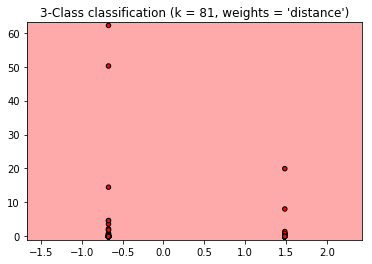

In [45]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
from matplotlib.colors import ListedColormap

#X = df_scaledTrainFillX.iloc[:, :2]
X = topScaledTrainFillX[['koi_fpflag_ss', 'koi_prad']]
y = exoTrainFillY
h=0.1
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
#plot KNN decision boundaries
knnClf.fit(X, y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knnClf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')" % (81, 'distance'))

plt.show()